In [1]:
#Load dataset
from google.colab import files
uploaded = files.upload()

Saving cleaned_data.csv to cleaned_data.csv



Model: BaggingR
MAE : 1.7327
MSE : 7.7437
R2  : 0.9980
PSNR: 40.5069 dB
SNR : 31.8611 dB


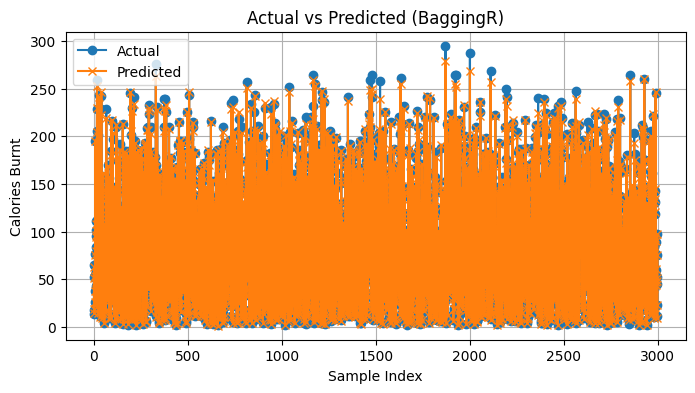


Model: RFR
MAE : 1.7279
MSE : 7.6858
R2  : 0.9981
PSNR: 40.5395 dB
SNR : 31.8937 dB


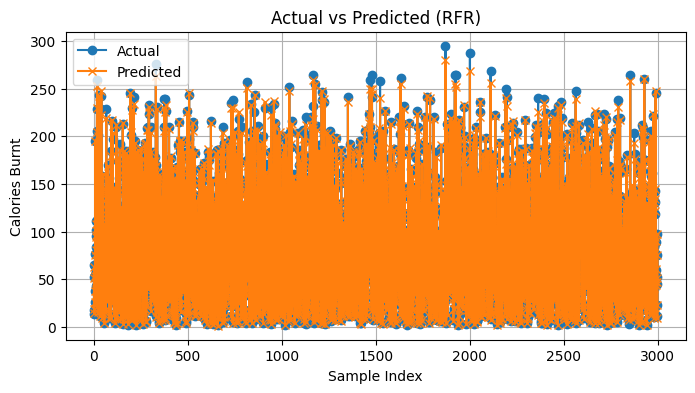


Model: GBDTR
MAE : 2.7357
MSE : 14.7690
R2  : 0.9963
PSNR: 37.7029 dB
SNR : 29.0571 dB


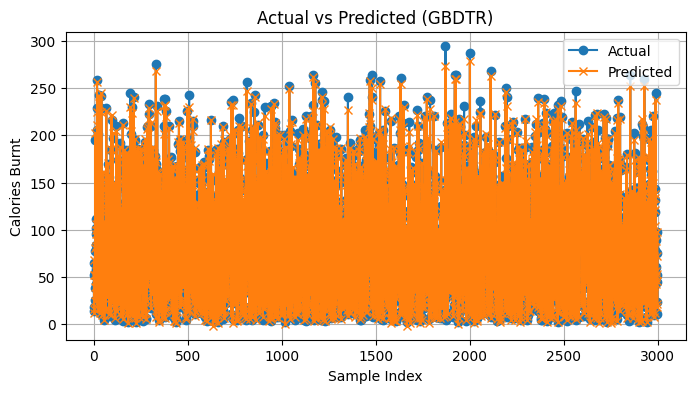


Model: XGBOOSTR
MAE : 1.2941
MSE : 3.9176
R2  : 0.9990
PSNR: 43.4663 dB
SNR : 34.8204 dB


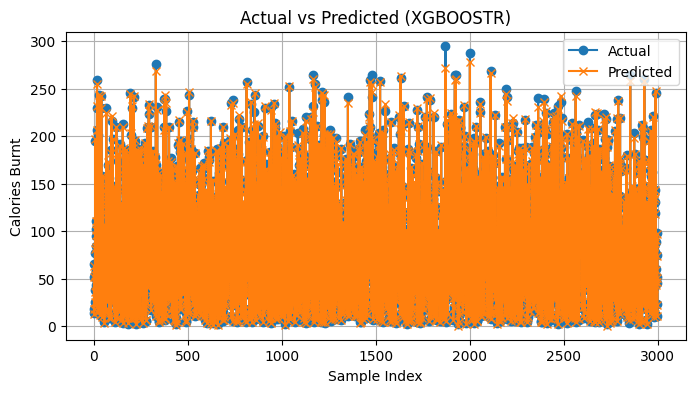


Model: VotingR
MAE : 3.9490
MSE : 31.8454
R2  : 0.9919
PSNR: 34.3660 dB
SNR : 25.7201 dB


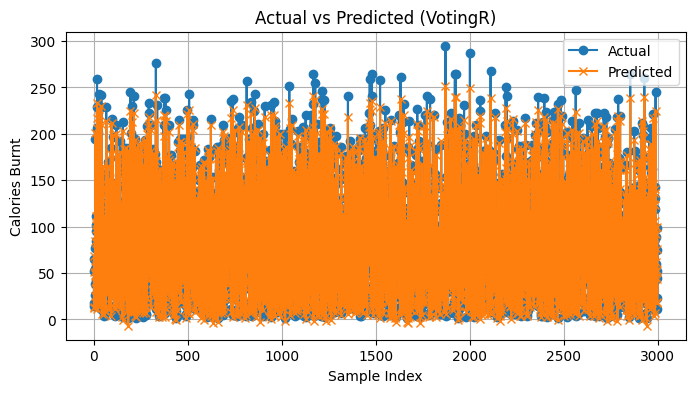


Model: StackingR
MAE : 1.7964
MSE : 8.1578
R2  : 0.9979
PSNR: 40.2807 dB
SNR : 31.6348 dB


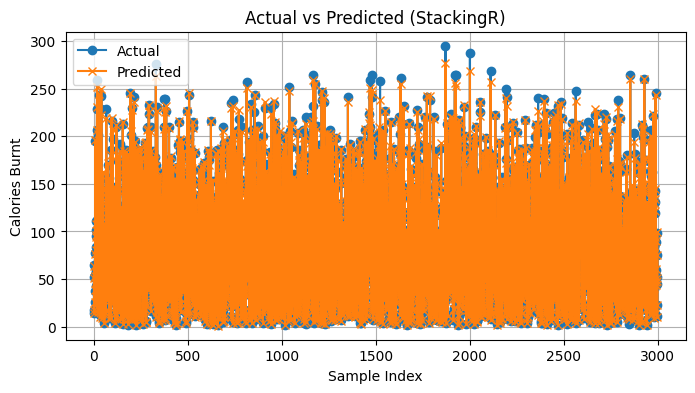


Summary of all models:
                 MAE        MSE        R2       PSNR        SNR
BaggingR   1.732723   7.743744  0.998039  40.506930  31.861054
RFR        1.727903   7.685837  0.998054  40.539528  31.893652
GBDTR      2.735658  14.768961  0.996260  37.702941  29.057064
XGBOOSTR   1.294074   3.917582  0.999008  43.466259  34.820382
VotingR    3.949021  31.845399  0.991937  34.365973  25.720097
StackingR  1.796385   8.157847  0.997934  40.280685  31.634808


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regression models
from sklearn.ensemble import (
    BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor,
    VotingRegressor, StackingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
from xgboost import XGBRegressor

# Step 1: Load the dataset
file_path = 'cleaned_data.csv'  # Change path if needed
df = pd.read_csv(file_path)

# Drop user ID column if still present
if 'userID' in df.columns:
    df = df.drop(columns=['userID'])

# Step 2: Features and Target
# Assuming "Calories" is the target column (adjust if yours is different)
X = df.drop(columns=['Calories'])
y = df['Calories']

# Step 3: Train-Test Split (80% train, 20% test)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# ---- Function to calculate metrics ----
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # PSNR (Peak Signal-to-Noise Ratio)
    max_val = np.max(y_true)
    psnr = 20 * np.log10(max_val / np.sqrt(mse)) if mse != 0 else float('inf')

    # SNR (Signal-to-Noise Ratio)
    signal_power = np.mean(np.square(y_true))
    noise_power = np.mean(np.square(y_true - y_pred))
    snr = 10 * np.log10(signal_power / noise_power) if noise_power != 0 else float('inf')

    return mae, mse, r2, psnr, snr

# ---- Models to Evaluate ----
models = {
    "BaggingR": BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42),
    "RFR": RandomForestRegressor(n_estimators=100, random_state=42),
    "GBDTR": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBOOSTR": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0),
    "VotingR": VotingRegressor([
        ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
        ('lr', LinearRegression())
    ]),
    "StackingR": StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
            ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
        ],
        final_estimator=LinearRegression()
    )
}

# ---- Train, Predict, Evaluate ----
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae, mse, r2, psnr, snr = calculate_metrics(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "PSNR": psnr, "SNR": snr}

    print(f"\nModel: {name}")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"R2  : {r2:.4f}")
    print(f"PSNR: {psnr:.4f} dB")
    print(f"SNR : {snr:.4f} dB")

    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(y_test)), y_test.values, label='Actual', marker='o')
    plt.plot(range(len(y_test)), y_pred, label='Predicted', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel('Calories Burnt')
    plt.title(f'Actual vs Predicted ({name})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Final results summary as DataFrame
results_df = pd.DataFrame(results).T
print("\nSummary of all models:\n", results_df)

